# Convolutional Neural Network

## Supervised Learning with keras

Advantages
-----------------
- Works well on image recognition problems

Disadvantages
-----------------
- High computational cost.
- Slow without GPU
- Hard to build the architecture

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import os

# Download the data from our GitLab page
!wget https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/deepsolaris_images_selection.npy
!wget https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/deepsolaris_labels_selection.npy
data_directory = os.path.join('/content/')

--2023-11-21 10:13:25--  https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/deepsolaris_images_selection.npy
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16875128 (16M) [application/octet-stream]
Saving to: ‘deepsolaris_images_selection.npy’

deepsolaris_images_ 100%[===================>]  16.09M  --.-KB/s    in 0.1s    

2023-11-21 10:13:26 (124 MB/s) - ‘deepsolaris_images_selection.npy’ saved [16875128/16875128]

--2023-11-21 10:13:26--  https://gitlab.com/CBDS/kennisgebied_ai/-/raw/master/data/deepsolaris_labels_selection.npy
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8128 (7.9K) [application/octet-stream]
Saving to: ‘deepsolaris_labels_selecti

# Training a convolutional neural network

Convolutional neural networks are a specific type of neural networks especially suitable for image data. To show the advantages of a convolutional neural network, we will train two neural networks on a standard data set. The first neural network is a standard fully connected network. The second neural network is a convolutional neural network.  To train a neural network we need four things:
* the data, that we want to train the network on,
* an optimizer, to train the weights in the network,
* a neural network, a specific neural network structure that we want to train,
* a loss function,

## The DeepSolaris dataset

We will train both networks on the DeepSolaris data set. This data set is a subset of the data set that we use in the Center for Big Data Statistics for the detection of solar panels. The subset contains 1000 images of 75x75 pixels taken from the aerial picture of Heerlen. These images are divided over two classes: one class for the images containing solar panels and one class for the images that do not contain any solar panels. In the following we will first load the DeepSolaris, split it up in a training and a test set and prepare it for processing.

In [3]:
from sklearn.model_selection import train_test_split

deepsolaris_images = np.load(os.path.join(data_directory, "deepsolaris_images_selection.npy"))
deepsolaris_labels = np.load(os.path.join(data_directory, "deepsolaris_labels_selection.npy"))

x_train, x_test, y_train, y_test = train_test_split(deepsolaris_images, deepsolaris_labels, test_size=0.2, stratify=deepsolaris_labels)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((800, 75, 75, 3), (800,), (200, 75, 75, 3), (200,))

To get an idea of the the DeepSolaris data set let's first plot some of the pictures in the data set.

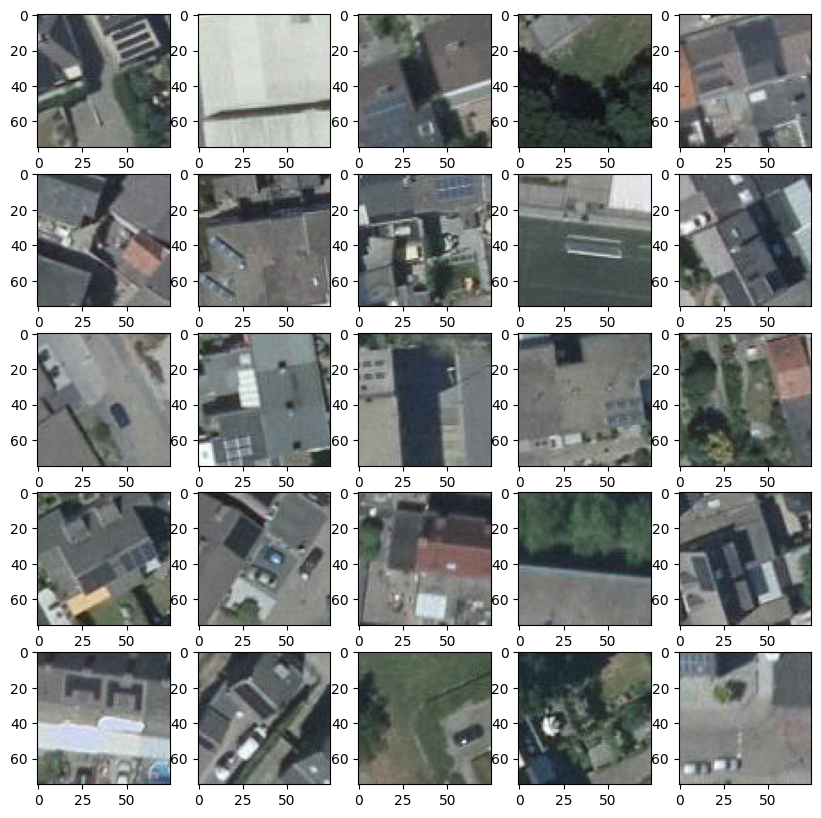

In [5]:
_, ax = plt.subplots(5,5, figsize=(10,10))
i = 0
for r in range(5):
    for c in range(5):
        ax[r, c].imshow(x_train[i][:,:, ::-1], cmap="gray")
        i += 1

To make it easier for neural networks to classify the images, we need to rescale the RGB values so that they fall in the range [0, 1]

In [6]:
x_train = x_train / 255
x_test = x_test / 255

To classify the images with the first fully connected neural network, we will need to reshape the images to one large vector that will be used as input to the first layer of the network. Each 75x75 image will therefore be resized to a vector with length 75x75x3 = 16875.

In [7]:
x_train_mlp = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test_mlp = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

Finally, we check the size of the training set and the test set and their corresponding labels. As can be seen we have 50000 images in the training set and 10000 images in the test set.

In [8]:
x_train_mlp.shape, y_train.shape, x_test_mlp.shape, y_test.shape

((800, 16875), (800,), (200, 16875), (200,))

## The Optimizer

After specifying the neural network structure we need to choose an optimizer that we are going to use to train the network. For this example, we are going for the standard Stochastic Gradient Descent optimizer. Stochastic Gradient Descent has several hyperparameters that we can configure: the learning rate, momentum, and nesterov momentum. We are going to use fairly standard values here, but in a real-world example you will spend a lot of time optimizing these hyperparameters before starting the actual training process.

In [9]:
from tensorflow.keras.optimizers.legacy import SGD

lr = 0.01
epochs = 10

sgd = SGD(learning_rate=lr, momentum=0.9, nesterov=True)

# Network structure 1: Multi Layer Perceptron

The first neural network we will train on the DeepSolaris data is a multi layer perceptron. All the layers in the network will be fully connected. The input layer will have 16875 neurons and the output layer will have a sigmoid layer of size one for a binary classification. For the hidden layers we are using a **ReLU** activation function which is defined as follows:

$max(0, x)$

The **ReLU** activation function is one of the most popular activation functions currently used, especially for Convolutional Neural Networks. The activation function of the output layer is a **sigmoid** function which gives a probability distribution for our classification. The sigmoid function is defined as follows:

$ S(x) = \dfrac{1}{1 + e^{-x}} $

The **sigmoid** output layer therefore gives the probability that the input vector contains a solar panel or not.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_shape=(16875,), activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In this case, the model is defined as **Sequential**, which means that all the layers that we add will follow each other in the order that they have been added to the model. All the layers we are adding are of type **Dense** which means that they are fully connected layers. In the first dense layer, we also need to specify the shape of the input vector (16875, ). Furthermore, for each layer we need to specify and activation function; Keras provides a convenient **activation** parameter for that. To check whether the network we constructed is correct Keras provides a handy **summary()** function:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1080064   
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1113857 (4.25 MB)
Trainable params: 1113857 (4.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## The loss function

To train the model, we first need to compile it. When compiling, we also specify the loss function that will be optimized by our optimizer. Because we are working with a classification with two classes we are going to use the **binary crossentropy**. In addition, we tell the model that we would like to monitor the **accuracy** during training, by passing an array to the metrics parameter.

In [12]:
model.compile(sgd, loss="binary_crossentropy", metrics=["accuracy"])

Next, we train the model on the training data. We specify a **batch size** of 32 and run the training over a total number of 30 epochs. Every epoch, the total data set of 800 images is split up in batches of 32 images which are used to adjust the network weights and thus train the network. After each epoch, the network performance is evaluated on the data set that we passed via the **validation_data** parameter.

In [13]:
H = model.fit(x_train_mlp, y_train, batch_size=32, epochs=epochs, validation_data=(x_test_mlp, y_test))

Epoch 1/10
25/25 [==============================] - 2s 49ms/step - loss: 0.7160 - accuracy: 0.5038 - val_loss: 0.6900 - val_accuracy: 0.5150
Epoch 2/10
25/25 [==============================] - 1s 22ms/step - loss: 0.6899 - accuracy: 0.5362 - val_loss: 0.7322 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 1s 23ms/step - loss: 0.7013 - accuracy: 0.4712 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
25/25 [==============================] - 1s 23ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/10
25/25 [==============================] - 1s 30ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 6/10
25/25 [==============================] - 1s 28ms/step - loss: 0.6928 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
25/25 [==============================] - 1s 31ms/step - loss: 0.6934 - accuracy: 0.4762 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
25

After training, we check the loss and accuracy during training and compare it to the loss and accuracy of the validation set. By plotting these metrics, we can see if training was successful or if the network was overfitting or underfitting.

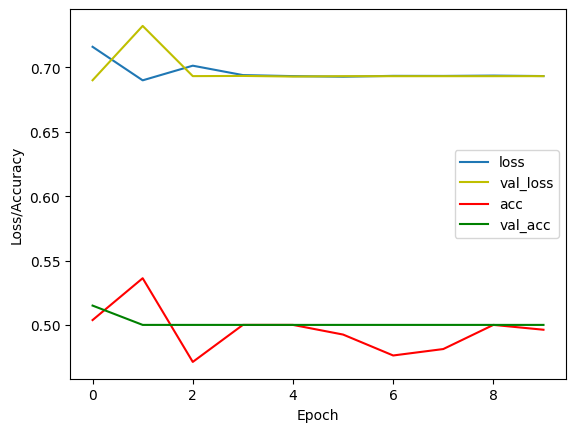

In [14]:
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], color="y", label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], color="r", label="acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], color="g", label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

Finally, we evaluate network performance on the test data using the sklearn **classification_report** function.

In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test_mlp)
print(classification_report(y_test.round(), y_pred.round()))

7/7 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.50      1.00      0.67       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Network structure 2: A Convolutional Neural Network

The second neural network we will train on the DeepSolaris data is a convolutional neural network. A convolutional neural network is a neural network that has convolutional layers. A convolutional layer contains several convolutional kernels. Convolutional kernels are well known constructs in computer vision that are used for a variety of purposes.  A convolutional kernel consists of a matrix that is *convolved* with the image; the kernel is used to calculate a weighted sum of an area of an image at a certain position (x, y). When applied to all the pixels in the image they can be used for example for blurring, sharpening, and edge detection. Below we show how to use the well-known **Sobel** kernels to bring out the edges in some of the DeepSolaris images.

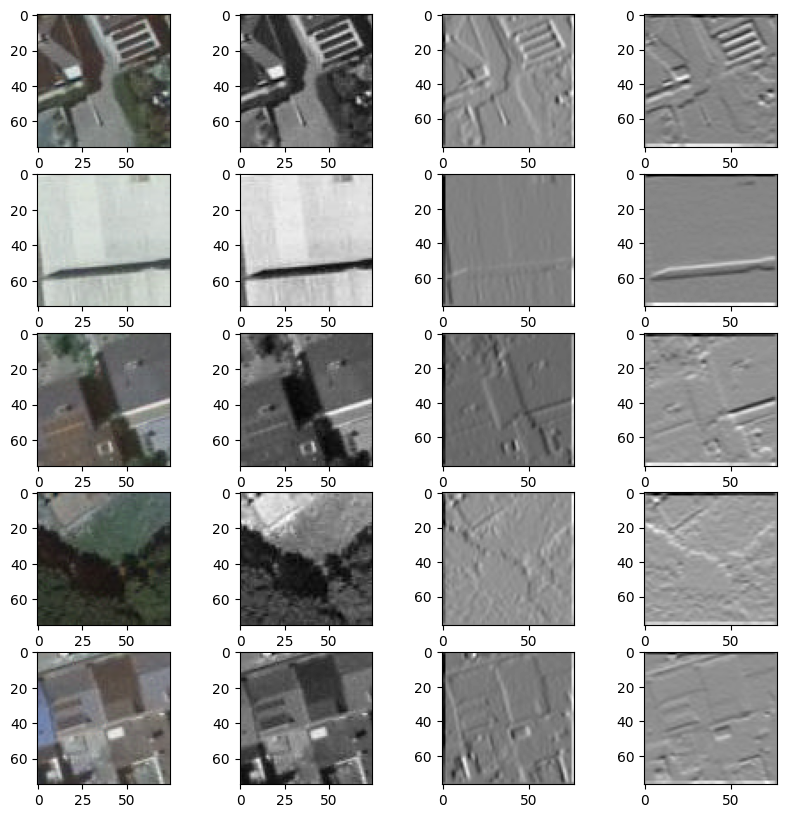

In [16]:
from scipy.signal import convolve2d

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]
                   ])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]
                   ])

_, ax = plt.subplots(5, 4, figsize=(10, 10))

for i in range(5):
    ax[i, 0].imshow(x_train[i])
    ax[i, 1].imshow(x_train[i].sum(axis=2),cmap="gray")
    ax[i, 2].imshow(convolve2d(x_train[i].sum(axis=2), sobel_x), cmap="gray")
    ax[i, 3].imshow(convolve2d(x_train[i].sum(axis=2), sobel_y), cmap="gray")



Instead of manually creating convolutional kernels like we did above, the power of convolutional neural networks comes from the fact that these kernels are *learned from the data*. We will now show how this works. To create the convolutional neural network, we are again using a **Sequential** model. The last hidden layers are the same as the ones that were used in fully connected model above. However, we see that the first hidden layer has been replaced by several other layers: Conv2D and MaxPooling2D layers. A Conv2D layer has three parameters. It has a *width*, a *height*, and a *depth*. The *width* and *height* give the dimension of the two dimensional convolutional kernel, in the first Conv2D layer this dimension is 5 x 5. The *depth* gives the number of convolutional kernels that can be learned in this layer of the network. The result of this layer is a 3D volume of activations. To convert this 3D volume back to an input that is suitable for a **Dense** layer, we need an extra layer in the network: the **Flatten** layer. In addition, we see the use of a **MaxPooling2D** layer, a special layer that "summarizes" the output of a **Conv2D** layer.

In [17]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (5, 5), padding="same", input_shape=(75, 75, 3), activation="relu"))
cnn_model.add(MaxPooling2D((3, 3), strides=(2, 2)))
cnn_model.add(Conv2D(64, (5, 5), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D((3, 3), strides=(2, 2)))
cnn_model.add(Conv2D(64, (5, 5), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D((3, 3), strides=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D((3, 3), strides=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dense(1, activation="sigmoid"))

To see if we create the model correct we are once more printing the summary of the model.

In [18]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)         

Like in the previous example, we again compile the method with a **binary_crossentropy** loss function and again we observe the **accuracy**.

In [19]:
cnn_model.compile(sgd, loss="binary_crossentropy", metrics=["accuracy"])

Training the convolutional network is also equivalent to training the fully connected network above. The only difference is the format of the training set. Instead of vectors with size 16875, we now offer the images with a dimension of 75x75x3.

In [20]:
H_cnn = cnn_model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
25/25 [==============================] - 20s 795ms/step - loss: 0.6952 - accuracy: 0.5075 - val_loss: 0.6917 - val_accuracy: 0.5150
Epoch 2/10
25/25 [==============================] - 22s 888ms/step - loss: 0.6914 - accuracy: 0.5450 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 19s 785ms/step - loss: 0.6907 - accuracy: 0.5225 - val_loss: 0.6876 - val_accuracy: 0.5750
Epoch 4/10
25/25 [==============================] - 20s 794ms/step - loss: 0.6870 - accuracy: 0.5525 - val_loss: 0.6851 - val_accuracy: 0.5550
Epoch 5/10
25/25 [==============================] - 22s 906ms/step - loss: 0.6799 - accuracy: 0.6100 - val_loss: 0.6954 - val_accuracy: 0.5100
Epoch 6/10
25/25 [==============================] - 19s 779ms/step - loss: 0.6755 - accuracy: 0.5713 - val_loss: 0.6768 - val_accuracy: 0.6000
Epoch 7/10
25/25 [==============================] - 19s 778ms/step - loss: 0.6710 - accuracy: 0.6187 - val_loss: 0.6611 - val_accuracy: 0.6450

To see if we have trained the model correctly, we plot the loss and accuracy for the training and validation sets and see if they develop similarly.

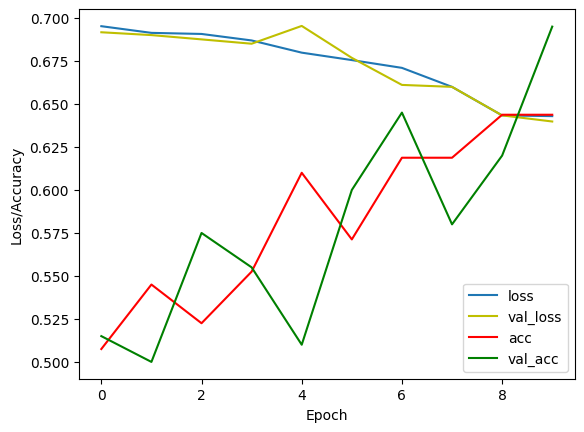

In [21]:
plt.figure()
plt.plot(np.arange(0, epochs), H_cnn.history["loss"], label="loss")
plt.plot(np.arange(0, epochs), H_cnn.history["val_loss"], color="y", label="val_loss")
plt.plot(np.arange(0, epochs), H_cnn.history["accuracy"], color="r", label="acc")
plt.plot(np.arange(0, epochs), H_cnn.history["val_accuracy"], color="g", label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

Finally, we once again print a classification report for the test set; we see that adding a convolutional layer improves the classification results considerably.

In [22]:
from sklearn.metrics import classification_report

y_pred_cnn = cnn_model.predict(x_test)
print(classification_report(y_test.round(), y_pred_cnn.round()))

7/7 [==============================] - 2s 211ms/step
              precision    recall  f1-score   support

           0       0.84      0.48      0.61       100
           1       0.64      0.91      0.75       100

    accuracy                           0.69       200
   macro avg       0.74      0.70      0.68       200
weighted avg       0.74      0.69      0.68       200



## Using out-of-the-box CNNs with Keras

Instead of defining our own convolution neural network, we can also use one of the state-of-the-art convolutional neural networks that Keras provides. The following networks are available within Keras:

* Xception
* VGG16
* VGG19
* ResNet, ResNetV2, ResNeXt
* InceptionV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* DenseNet
* NASNet

Each of these networks provides weights that have been pre-trained on the ImageNet data set, a large data set of 1.2 million images. By using a network with pre-trained weights we can reuse the convolutional kernels that have been derived from this large data set and adapt to our specific classification task. Using pre-trained weights and starting our training process from there is called **transfer learning**. An example of using a pre-trained network provided by Keras is given below.

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", input_shape=(75,75,3), include_top=False)
last_conv_layer = base_model.get_layer("block5_pool")
x = Flatten()(last_conv_layer.output)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

vgg16 = Model(base_model.input, predictions)
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                              

In [24]:
vgg16.compile(sgd, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H_vgg16 = vgg16.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
25/25 [==============================] - 208s 8s/step - loss: 0.7424 - accuracy: 0.5125 - val_loss: 0.8962 - val_accuracy: 0.5000
Epoch 2/10
10/25 [===========>..................] - ETA: 1:49 - loss: 0.7509 - accuracy: 0.4719

In [ ]:
plt.figure()
plt.plot(np.arange(0, epochs), H_vgg16.history["loss"], label="loss")
plt.plot(np.arange(0, epochs), H_vgg16.history["val_loss"], color="y", label="val_loss")
plt.plot(np.arange(0, epochs), H_vgg16.history["accuracy"], color="r", label="acc")
plt.plot(np.arange(0, epochs), H_vgg16.history["val_accuracy"], color="g", label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")